In [11]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/oskardale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
df0 = pd.read_csv('../0_data/statements.csv')
df1 = pd.read_csv('../0_data/eu_debate_transcripts_translated.csv')
df_chatgpt = df0[df0.provider == 'chatgpt']
df_deepseek = df0[df0.provider == 'deepseek']
documents_chatgpt = df_chatgpt.statement.values.tolist()
documents_deepseek = df_deepseek.statement.values.tolist()
documents_parliament = df1.translated_text.values.tolist()

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(doc):
    texts = []
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    tokens = word_tokenize(doc.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens
             if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
    return tokens

clean_chatgpt = [preprocess_text(doc) for doc in documents_chatgpt]
clean_deepseek = [preprocess_text(doc) for doc in documents_deepseek]
clean_parliament = [preprocess_text(doc) for doc in documents_parliament]


all_documents = clean_parliament + clean_chatgpt + clean_deepseek
labels = ['Real'] * len(clean_parliament) + ['ChatGPT'] * len(clean_chatgpt) + ['DeepSeek'] * len(clean_deepseek)

In [16]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

def get_sentence_embeddings(sentences):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]
    model = Doc2Vec(documents, vector_size=384, window=2, min_count=1, workers=4)
    sentence_vectors = [model.infer_vector(tokens) for tokens in sentences]
    return np.array(sentence_vectors)

embeddings = get_sentence_embeddings(all_documents)

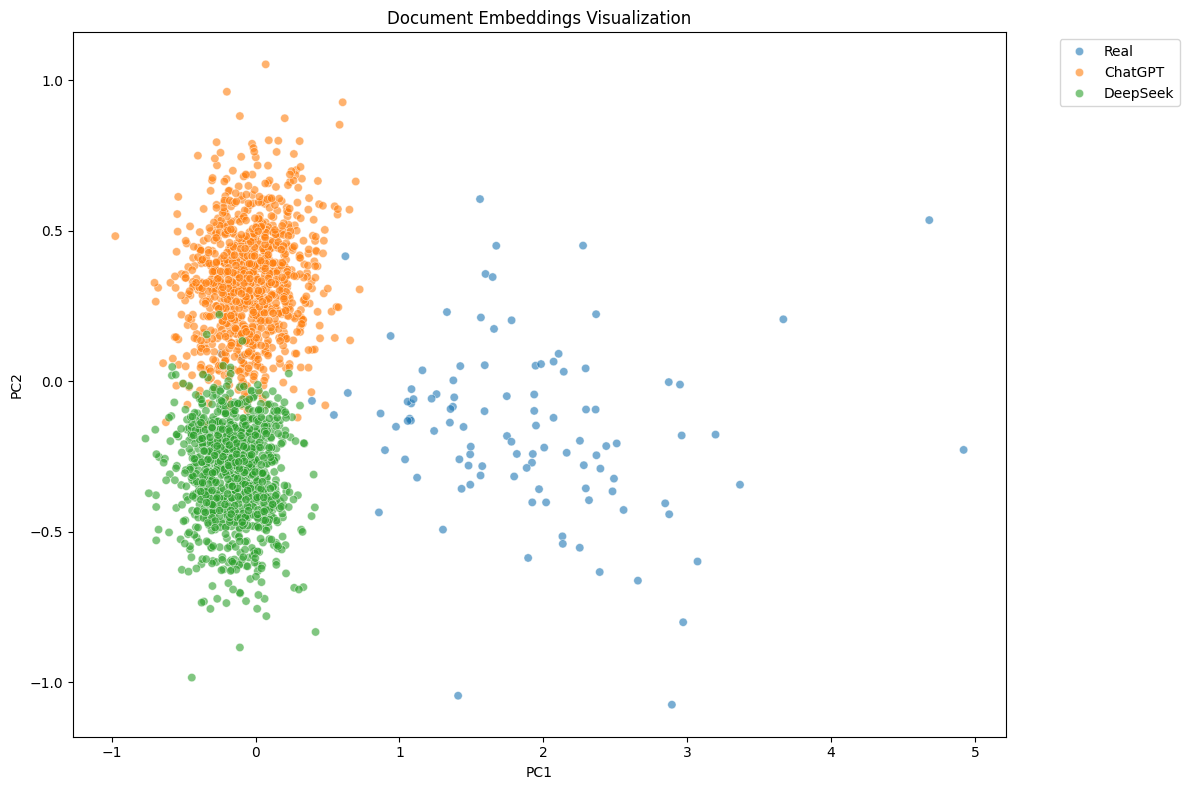

In [17]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plot_df = pd.DataFrame(embeddings_2d, columns=['PC1', 'PC2'])
plot_df['Source'] = labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Source', alpha=0.6)
plt.title('Document Embeddings Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

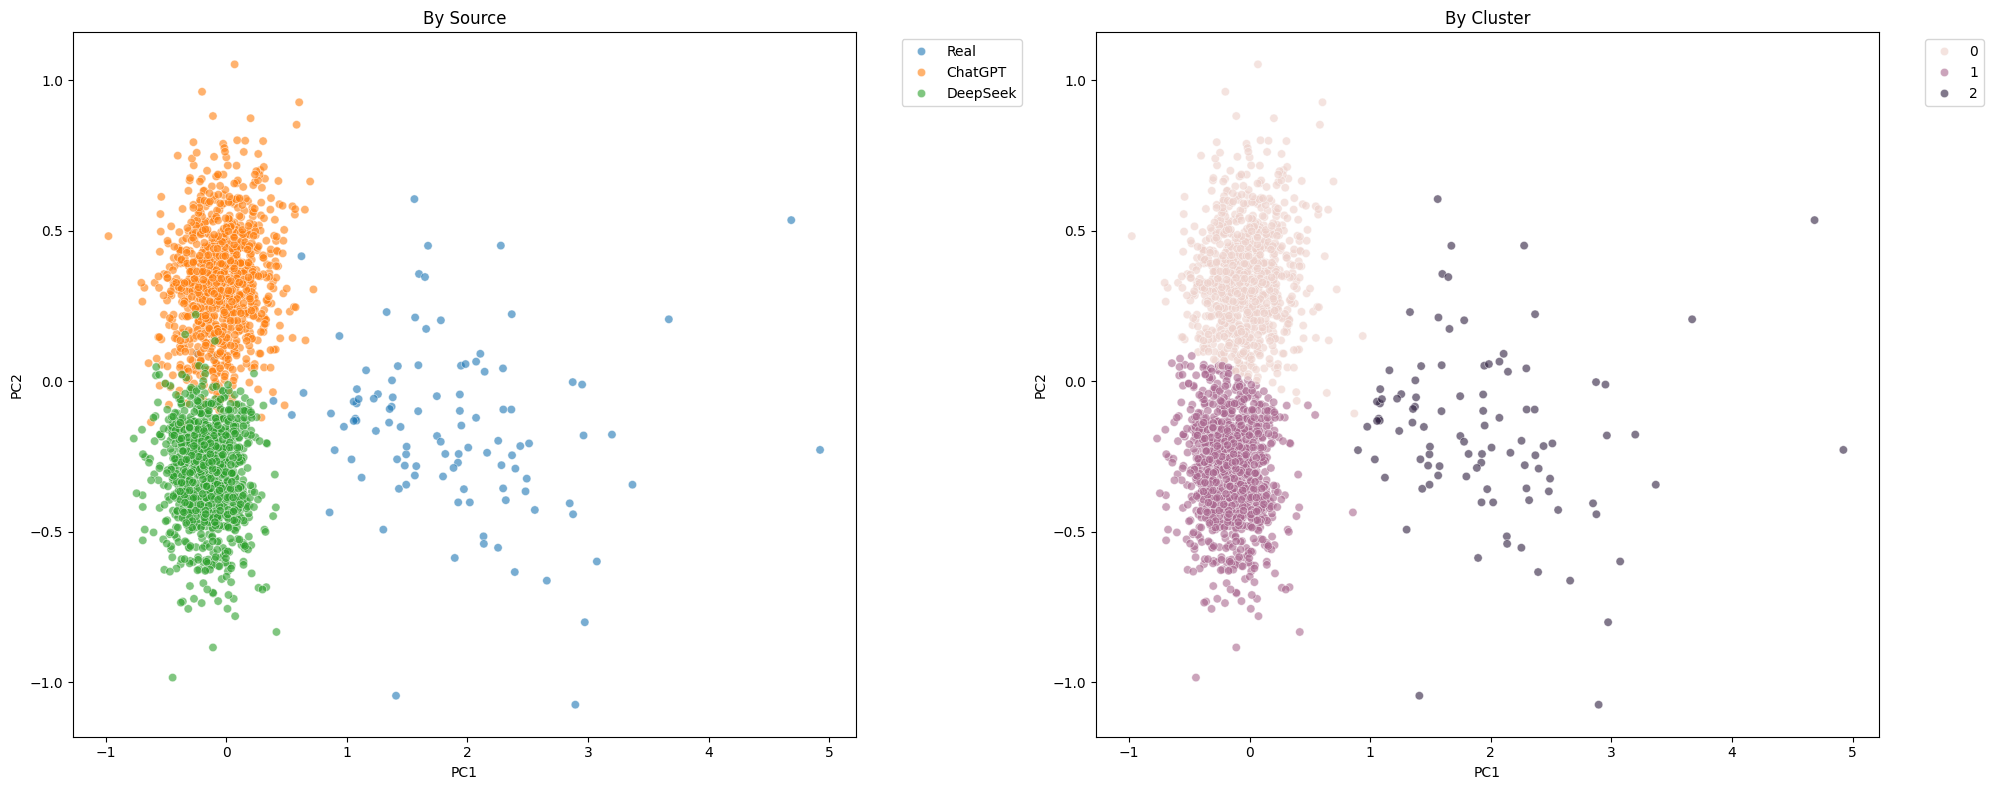


Cluster Composition:
Source   ChatGPT  DeepSeek  Real
Cluster                         
0            937         4     7
1             63       996     2
2              0         0    99


In [18]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

plot_df['Cluster'] = cluster_labels

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Source', alpha=0.6, ax=ax1)
ax1.set_title('By Source')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', alpha=0.6, ax=ax2)
ax2.set_title('By Cluster')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

cluster_composition = pd.crosstab(plot_df['Cluster'], plot_df['Source'])
print("\nCluster Composition:")
print(cluster_composition)